# Data dictionary

**Bank client data**
* 1 - age 
* 2 - job : type of job 
* 3 - marital : marital status
* 4 - education 
* 5 - default: has credit in default? 
* 6 - housing: has housing loan? 
* 7 - loan: has personal loan?
* 8 - balance in account

**Related to previous contact**
* 8 - contact: contact communication type
* 9 - month: last contact month of year
* 10 - day_of_week: last contact day of the week
* 11 - duration: last contact duration, in seconds*

**Other attributes**
* 12 - campaign: number of contacts performed during this campaign and for this client
* 13 - pdays: number of days that passed by after the client was last contacted from a previous campaign
* 14 - previous: number of contacts performed before this campaign and for this client
* 15 - poutcome: outcome of the previous marketing campaign

**Output variable (desired target):has the client subscribed a term deposit?**

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import graphviz
import pydotplus
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image 

/Users/Gesi/anaconda3/lib/python3.6/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [4]:
data = pd.read_csv("bank-full.csv")
data.head()

age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome Target  
0  unknown    5   may       261         1     -1         0  unknown     no  
1  unknown    5   may       151         1     -1         0  unknown     no  
2  unknown    5   may        76         1     -1         0  unknown     no  
3  unknown    5   may        92         1     -1         0  unknown     no  
4  unknown    5   may       198         1     -1         0  unknown     no

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
Target       45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


There are quite a few categorical independent variables. There aren't any null values (doesn't guarantee there aren't any incorrect or missing values).

In [6]:
data.describe().T

count         mean          std     min    25%    50%     75%  \
age       45211.0    40.936210    10.618762    18.0   33.0   39.0    48.0   
balance   45211.0  1362.272058  3044.765829 -8019.0   72.0  448.0  1428.0   
day       45211.0    15.806419     8.322476     1.0    8.0   16.0    21.0   
duration  45211.0   258.163080   257.527812     0.0  103.0  180.0   319.0   
campaign  45211.0     2.763841     3.098021     1.0    1.0    2.0     3.0   
pdays     45211.0    40.197828   100.128746    -1.0   -1.0   -1.0    -1.0   
previous  45211.0     0.580323     2.303441     0.0    0.0    0.0     0.0   

               max  
age           95.0  
balance   102127.0  
day           31.0  
duration    4918.0  
campaign      63.0  
pdays        871.0  
previous     275.0

Following data are skewed and have outliers to the right: age, balance, campaign, pdays and previous (not completely surprising as many may not have been contacted before this campaign).
Pdays seems to have many values set to -1. Despite the desccription of data, it seems that -1 means the client was not previously contacted. This fits completely with the data captured by the 'previous' variable as well.

### Age

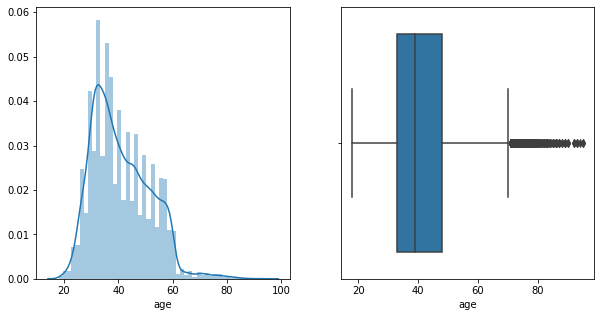

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.distplot(data['age'], ax = ax1)
sns.boxplot(data['age'], ax = ax2)
plt.show()

There are quite a few outliers to the right, with the median being around 40. 

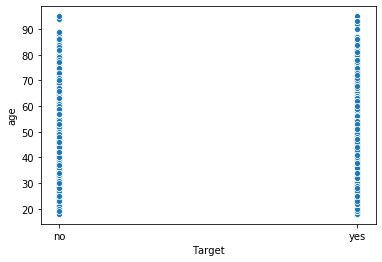

In [8]:
sns.scatterplot(data['Target'],data['age'])

There isn't a clear relation between older age and the target value.

### Job

In [9]:
data['job'].unique()

array(['management', 'technician', 'entrepreneur', 'blue-collar',
       'unknown', 'retired', 'admin.', 'services', 'self-employed',
       'unemployed', 'housemaid', 'student'], dtype=object)

In [10]:
data['job']=data['job'].astype('category')

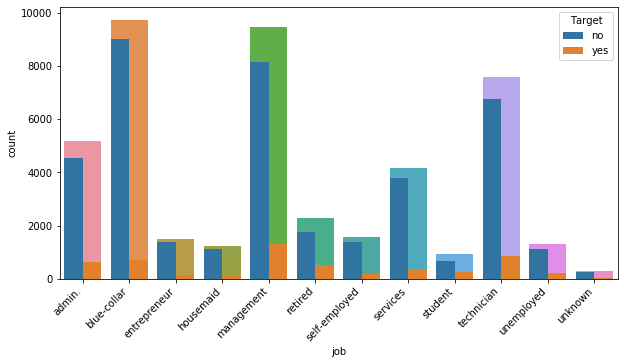

In [11]:
plt.figure(figsize=(10,5))
plt.xticks(rotation=45, horizontalalignment='right')
sns.countplot(data['job'])
sns.countplot(data['job'], hue='Target', data=data)

In [12]:
pd.crosstab(data['job'], data['Target'], normalize='index').sort_values(by='yes',ascending=False )

Target               no       yes
job                              
student        0.713220  0.286780
retired        0.772085  0.227915
unemployed     0.844973  0.155027
management     0.862444  0.137556
admin.         0.877973  0.122027
self-employed  0.881571  0.118429
unknown        0.881944  0.118056
technician     0.889430  0.110570
services       0.911170  0.088830
housemaid      0.912097  0.087903
entrepreneur   0.917283  0.082717
blue-collar    0.927250  0.072750

Students have the highest conversion rate, while the blue-collar have the lowest.

### Martial

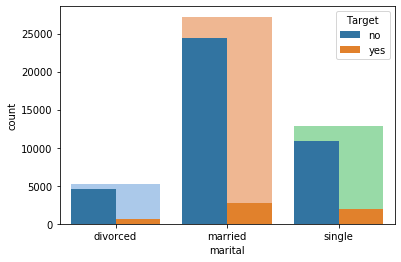

In [13]:
data['marital']=data['marital'].astype('category')
sns.countplot(data['marital'], palette='pastel')
sns.countplot(data['marital'], hue='Target', data=data)

In [14]:
pd.crosstab(data['marital'], data['Target'], normalize='index').sort_values(by='yes',ascending=False )

Target          no       yes
marital                     
single    0.850508  0.149492
divorced  0.880545  0.119455
married   0.898765  0.101235

There doesn't seem to be a direct relation between marital status and the outcome. The proportion of success/failure in each job is in a similar range.

### Education

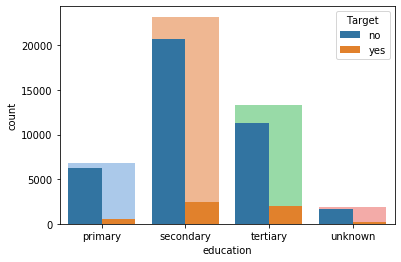

In [15]:
data['education']=data['education'].astype('category')
sns.countplot(data['education'], palette='pastel')
sns.countplot(data['education'], hue='Target', data=data)

In [16]:
pd.crosstab(data['education'], data['Target'], normalize='index').sort_values(by='yes',ascending=False )

Target           no       yes
education                    
tertiary   0.849936  0.150064
unknown    0.864297  0.135703
secondary  0.894406  0.105594
primary    0.913735  0.086265

The ratio of conversion is more or less similar for most levels of education except for those with 'Primary' level of education which have the lowest conversion rate. 

### Default

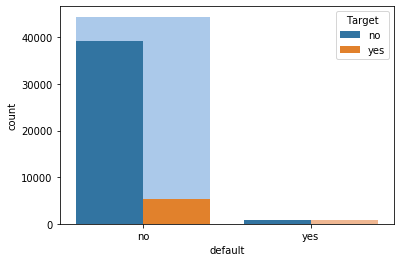

In [17]:
data['default']=data['default'].astype('category')
sns.countplot(data['default'], palette='pastel')
sns.countplot(data['default'], hue='Target', data=data)

In [18]:
pd.crosstab(data['default'], data['Target'], normalize='index').sort_values(by='yes',ascending=False )

Target         no       yes
default                    
no       0.882039  0.117961
yes      0.936196  0.063804

In [19]:
data.groupby('default')['Target'].value_counts()

default  Target
no       no        39159
         yes        5237
yes      no          763
         yes          52
Name: Target, dtype: int64

There are very few positive 'default' datapoints, with no clear relation between the 'default' and the target variable. This variable is a candidate for being removed.

### Balance

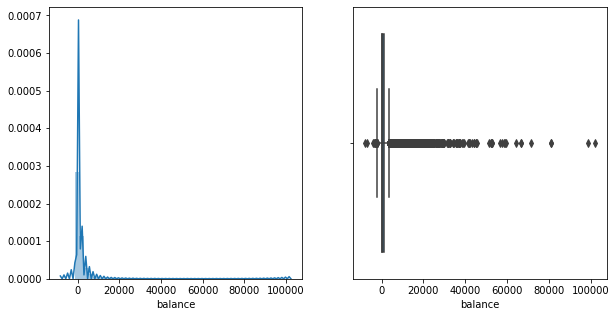

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.distplot(data['balance'], ax = ax1)
sns.boxplot(data['balance'], ax = ax2)
plt.show()

Balance is extremely skewed and has many outliers. This needs to be treated, or the models used need to be robust to outliers (e.g. Decision Trees).

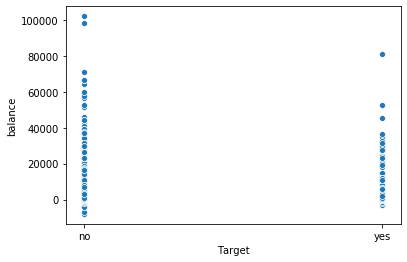

In [21]:
sns.scatterplot(data['Target'],data['balance'])

### Housing

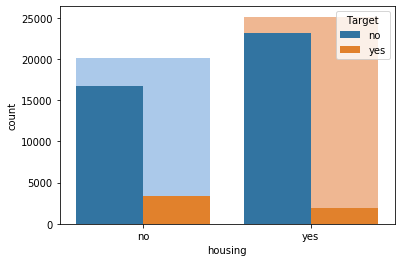

In [22]:
data['housing']=data['housing'].astype('category')
sns.countplot(data['housing'], palette='pastel')
sns.countplot(data['housing'], hue='Target', data=data)

In [23]:
pd.crosstab(data['housing'], data['Target'], normalize='index').sort_values(by='yes',ascending=False )

Target         no       yes
housing                    
no       0.832976  0.167024
yes      0.923000  0.077000

### Loan

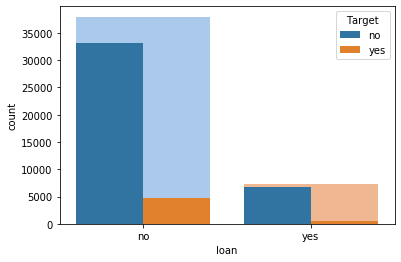

In [24]:
data['loan']=data['loan'].astype('category')
sns.countplot(data['loan'], palette='pastel')
sns.countplot(data['loan'], hue='Target', data=data)

In [25]:
pd.crosstab(data['loan'], data['Target'], normalize='index').sort_values(by='yes',ascending=False )

Target        no       yes
loan                      
no      0.873443  0.126557
yes     0.933186  0.066814

### Contact

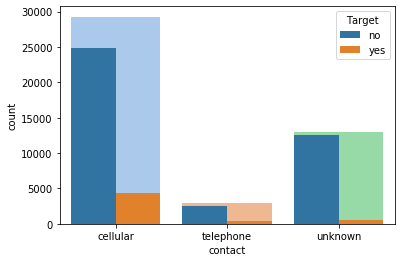

In [26]:
data['contact']=data['contact'].astype('category')
sns.countplot(data['contact'], palette='pastel')
sns.countplot(data['contact'], hue='Target', data=data)

In [27]:
pd.crosstab(data['contact'], data['Target'], normalize='index').sort_values(by='yes',ascending=False )

Target           no       yes
contact                      
cellular   0.850811  0.149189
telephone  0.865795  0.134205
unknown    0.959293  0.040707

### Day

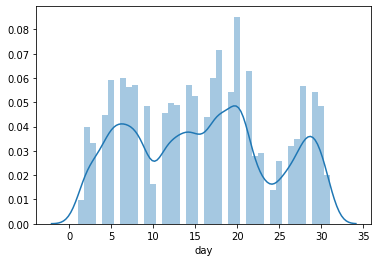

In [28]:
data['day']=data['day'].astype('category')
sns.distplot(data['day'])

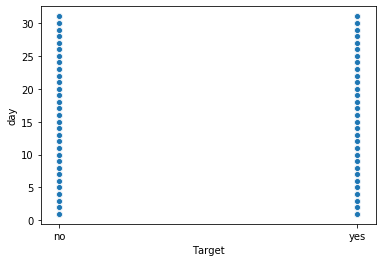

In [29]:
sns.scatterplot(data['Target'], data['day'])


In [30]:
pd.crosstab(data['day'], data['Target'], normalize='index').sort_values(by='yes',ascending=False )

Target        no       yes
day                       
1       0.720497  0.279503
10      0.769084  0.230916
30      0.826948  0.173052
22      0.829834  0.170166
3       0.835032  0.164968
4       0.840830  0.159170
25      0.841667  0.158333
12      0.847785  0.152215
13      0.847950  0.152050
2       0.859242  0.140758
15      0.860247  0.139753
24      0.861298  0.138702
16      0.864311  0.135689
23      0.865815  0.134185
27      0.866191  0.133809
11      0.877620  0.122380
9       0.885330  0.114670
14      0.886364  0.113636
5       0.887435  0.112565
26      0.887923  0.112077
8       0.890879  0.109121
21      0.900790  0.099210
18      0.901213  0.098787
6       0.906315  0.093685
17      0.909232  0.090768
7       0.913594  0.086406
28      0.921858  0.078142
29      0.926074  0.073926
31      0.928460  0.071540
20      0.930233  0.069767
19      0.930563  0.069437

Interestingly, even though on the 20th of each month the frequency of calls is higher, the conversion rate is the lowest.

### Month

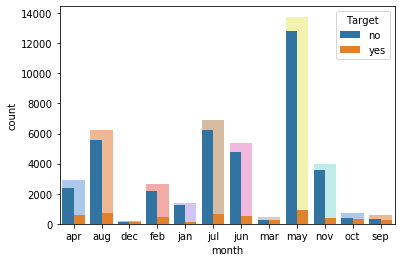

In [31]:
data['month']=data['month'].astype('category')
sns.countplot(data['month'], palette='pastel')
sns.countplot(data['month'], hue='Target', data=data)

In [32]:
pd.crosstab(data['month'], data['Target'], normalize='index').sort_values(by='yes',ascending=False )

Target        no       yes
month                     
mar     0.480084  0.519916
dec     0.532710  0.467290
sep     0.535406  0.464594
oct     0.562331  0.437669
apr     0.803206  0.196794
feb     0.833522  0.166478
aug     0.889867  0.110133
jun     0.897772  0.102228
nov     0.898489  0.101511
jan     0.898788  0.101212
jul     0.909065  0.090935
may     0.932805  0.067195

The better conversion rates are for the quiet months of the campaign. The peak months when the campain was running, the ratio of conversion is generally lower. 

### Duration

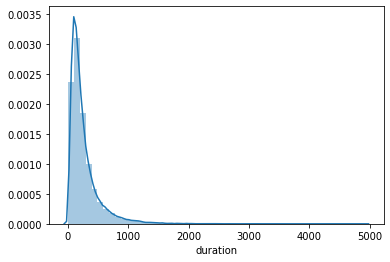

In [33]:
sns.distplot(data['duration'])

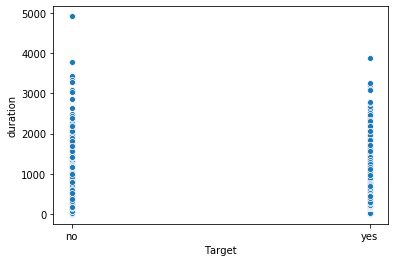

In [34]:
sns.scatterplot(data['Target'], data['duration'])

This attribute highly affects the output target (e.g., if duration=0 then target is always 0). Yet, the duration is until after a call is performed. Also, after the end of the call the target is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

### Campaign
Number of contacts performed during this campaign and for this client (numeric, includes last contact)

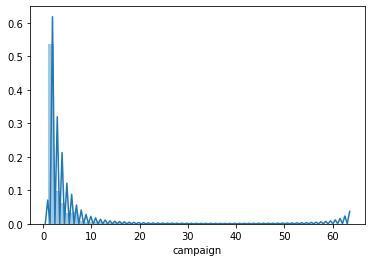

In [35]:
sns.distplot(data['campaign'])

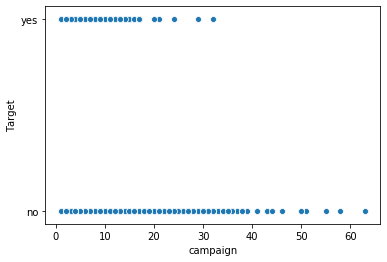

In [36]:
sns.scatterplot(data['campaign'], data['Target'])

Interestingly, after a certain point more contacts does not result in a yes outcome. So there is no direct relationship.

### Passed Days

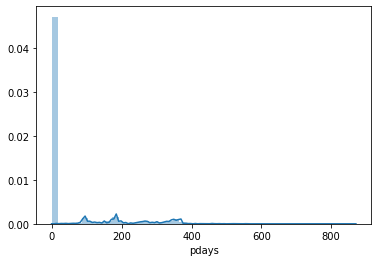

In [37]:
sns.distplot(data['pdays'])

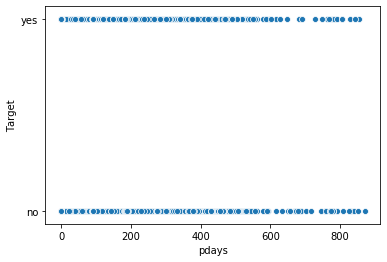

In [38]:
sns.scatterplot(data['pdays'], data['Target'])

The number of days passed since last campaign doesn't seem to have a direct relationship with the outcome.

In [39]:
no_previous_contact = data[data['pdays']<0]
no_previous_contact.shape

(36954, 17)

In [40]:
no_previous_contact[no_previous_contact['previous']>0]

Empty DataFrame
Columns: [age, job, marital, education, default, balance, housing, loan, contact, day, month, duration, campaign, pdays, previous, poutcome, Target]
Index: []

Comparing -1 values for 'pdays' and the non-zero 'previous' variables, we can conclude that -1 means there were no previous contacts. As the proportion of those not contacted before is quite hight and there was no obvious relation between the number of days passed and the outcome, we could drop this variable and only use the 'previous' variable instead.

### Previous

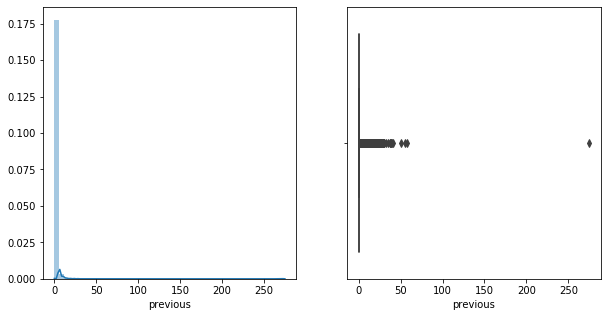

In [41]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.distplot(data['previous'], ax = ax1)
sns.boxplot(data['previous'], ax = ax2)
plt.show()

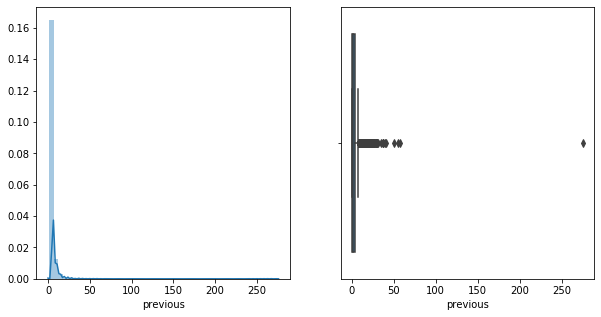

In [42]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
prev_contact = data[data['previous']>0]
sns.distplot(prev_contact['previous'], ax = ax1)
sns.boxplot(prev_contact['previous'], ax = ax2)
plt.show()

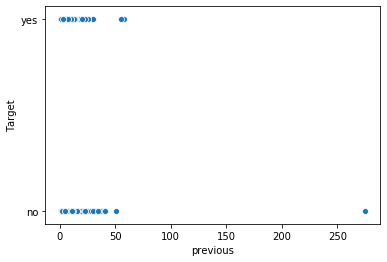

In [43]:
sns.scatterplot(prev_contact['previous'],prev_contact['Target'])

In [44]:
data['prev_cat'] = (data['previous']>0).astype('category')

Creating a categorial variable to be used if 'previous' were to be dropped.

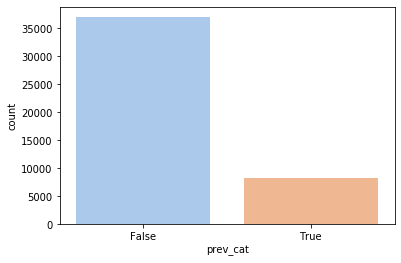

In [45]:
sns.countplot(data['prev_cat'], palette='pastel')

In [46]:
pd.crosstab(data['prev_cat'], data['Target'], normalize='index').sort_values(by='yes',ascending=False )

Target          no       yes
prev_cat                    
True      0.769287  0.230713
False     0.908427  0.091573

### Poutcome

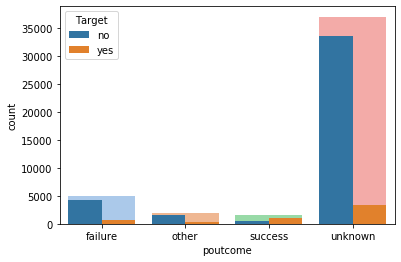

In [47]:
data['poutcome']=data['poutcome'].astype('category')
sns.countplot(data['poutcome'], palette='pastel')
sns.countplot(data['poutcome'], hue='Target', data=data)

Most of the previous outcome is unknown. There seems to be a relation between previous success and current success though. 

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 18 columns):
age          45211 non-null int64
job          45211 non-null category
marital      45211 non-null category
education    45211 non-null category
default      45211 non-null category
balance      45211 non-null int64
housing      45211 non-null category
loan         45211 non-null category
contact      45211 non-null category
day          45211 non-null category
month        45211 non-null category
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null category
Target       45211 non-null object
prev_cat     45211 non-null category
dtypes: category(11), int64(6), object(1)
memory usage: 2.9+ MB


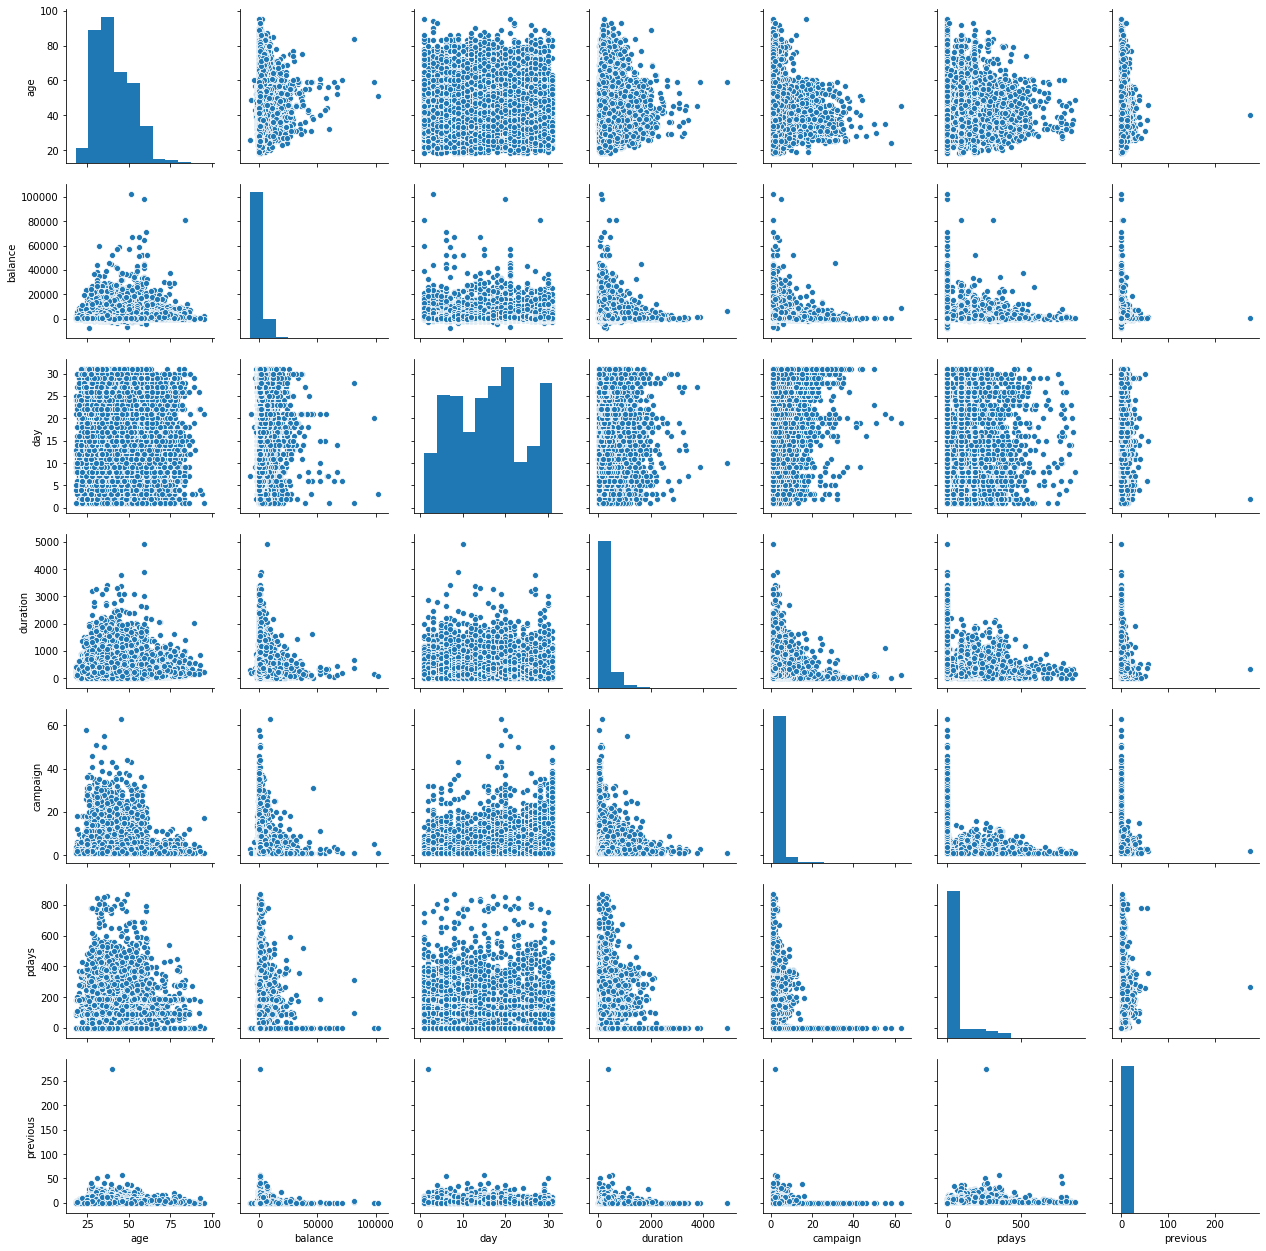

In [49]:
sns.pairplot(data.drop(['prev_cat'],axis=1))

In [50]:
data.corr()

age   balance  duration  campaign     pdays  previous
age       1.000000  0.097783 -0.004648  0.004760 -0.023758  0.001288
balance   0.097783  1.000000  0.021560 -0.014578  0.003435  0.016674
duration -0.004648  0.021560  1.000000 -0.084570 -0.001565  0.001203
campaign  0.004760 -0.014578 -0.084570  1.000000 -0.088628 -0.032855
pdays    -0.023758  0.003435 -0.001565 -0.088628  1.000000  0.454820
previous  0.001288  0.016674  0.001203 -0.032855  0.454820  1.000000

No strong correlation between variables.

## Cleaning data

In [82]:
cdata = data.drop('duration',axis=1)

In [83]:
def binning(col, cut_points, labels=None):
  #Define min and max values:
  minval = col.min()
  maxval = col.max()

  #create list by adding min and max to cut_points
  break_points = [minval] + cut_points + [maxval]

  #if no labels provided, use default labels 0 ... (n-1)
  if not labels:
    labels = range(len(cut_points)+1)

  #Binning using cut function of pandas
  colBin = pd.cut(col,bins=break_points,labels=labels,include_lowest=True)
  return colBin

In [84]:
#Binning balance
cut_points = [0,500,1000, 1500,2000]
labels = ["very low","low","medium","high", "very high", "highest"]
cdata['balance_range'] = binning(cdata['balance'], cut_points, labels)
cdata['balance_range'].value_counts()

low          16385
highest       8501
very low      7280
medium        6915
high          3736
very high     2394
Name: balance_range, dtype: int64

In [85]:
#Binning campaign
cut_points = [2,3,4]
labels = ["<=2","3","4",">4"]
cdata['campaign_range'] = binning(cdata['campaign'], cut_points, labels)
cdata['campaign_range'].value_counts()

<=2    30049
>4      6119
3       5521
4       3522
Name: campaign_range, dtype: int64

In [86]:
cdata.drop(['balance','campaign'], axis=1, inplace=True)
cdata.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'day', 'month', 'pdays', 'previous', 'poutcome', 'Target',
       'prev_cat', 'balance_range', 'campaign_range'],
      dtype='object')

In [87]:
cdata.head()

age           job  marital  education default housing loan  contact day  \
0   58    management  married   tertiary      no     yes   no  unknown   5   
1   44    technician   single  secondary      no     yes   no  unknown   5   
2   33  entrepreneur  married  secondary      no     yes  yes  unknown   5   
3   47   blue-collar  married    unknown      no     yes   no  unknown   5   
4   33       unknown   single    unknown      no      no   no  unknown   5   

  month  pdays  previous poutcome Target prev_cat balance_range campaign_range  
0   may     -1         0  unknown     no    False       highest            <=2  
1   may     -1         0  unknown     no    False           low            <=2  
2   may     -1         0  unknown     no    False           low            <=2  
3   may     -1         0  unknown     no    False     very high            <=2  
4   may     -1         0  unknown     no    False           low            <=2

## Preparing Data

In [88]:
X = cdata.loc[:,cdata.columns!='Target']
y = cdata['Target']

le = preprocessing.LabelEncoder()
y = pd.Series(le.fit_transform(y))

#### Add Dummy variables for categorical data

In [89]:
X = pd.get_dummies(X, drop_first=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 77 columns):
age                        45211 non-null int64
pdays                      45211 non-null int64
previous                   45211 non-null int64
job_blue-collar            45211 non-null uint8
job_entrepreneur           45211 non-null uint8
job_housemaid              45211 non-null uint8
job_management             45211 non-null uint8
job_retired                45211 non-null uint8
job_self-employed          45211 non-null uint8
job_services               45211 non-null uint8
job_student                45211 non-null uint8
job_technician             45211 non-null uint8
job_unemployed             45211 non-null uint8
job_unknown                45211 non-null uint8
marital_married            45211 non-null uint8
marital_single             45211 non-null uint8
education_secondary        45211 non-null uint8
education_tertiary         45211 non-null uint8
education_unknown          

#### Split Data

In [90]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=1,test_size=0.3) 

In [91]:
print("Positive target variables ratio in training data:",y_train.where(y==1).notnull().sum()/len(y_train))
print("Positive target variables ratio in test data:",y_test.where(y==1).notnull().sum()/len(y_test))

Positive target variables ratio in training data: 0.11811546118115461
Positive target variables ratio in test data: 0.11434680035387791


There is a high class imbalance as the ratio of positive target variables is only around 0.11. Hence, here accuracy will not be a reliable model performance measure and False Negative is very critical for this business case because a false negative is a customer who will potentially subscribe for a loan but who has been classified as 'will not subscribe'. Hence the most relevant model performance measure is recall.

#### Normalise data

In [93]:
X_train_std = X_train
X_train_std[['age','pdays','previous']] = X_train[['age','pdays','previous']].apply(zscore)
X_test_std = X_test
X_test_std[['age','pdays','previous']] = X_test[['age','pdays','previous']].apply(zscore)

/Users/Gesi/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


### Logistic Regression

In [94]:
lr_model = LogisticRegression(max_iter=200)
lr_model.fit(X_train_std, y_train)
y_pred_lr = lr_model.predict(X_test_std)

lr_report = metrics.classification_report(y_test,y_pred_lr)
print(lr_report)

              precision    recall  f1-score   support

           0       0.90      0.99      0.94     12013
           1       0.62      0.19      0.29      1551

    accuracy                           0.89     13564
   macro avg       0.76      0.59      0.61     13564
weighted avg       0.87      0.89      0.87     13564



   Predict 1  Predict 0
1        288       1263
0        180      11833


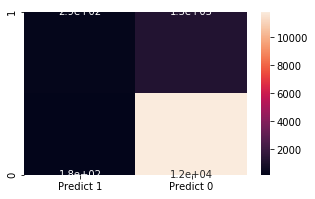

In [95]:
cm_lr = metrics.confusion_matrix(y_test, y_pred_lr, labels=[1, 0])

df_cm_lr = pd.DataFrame(cm_lr, index = ["1","0"],
                  columns = ["Predict 1","Predict 0"])
print(df_cm_lr)
plt.figure(figsize = (5,3))
sns.heatmap(df_cm_lr, annot=True)

### Decision Trees

In [96]:
dt_model = DecisionTreeClassifier(criterion = "entropy", random_state = 1, max_depth=5, min_samples_leaf=3)
dt_model.fit(X_train_std, y_train)
y_pred_dt = dt_model.predict(X_test_std)

dt_report = metrics.classification_report(y_test,y_pred_dt)
print(dt_report)

              precision    recall  f1-score   support

           0       0.90      0.99      0.94     12013
           1       0.65      0.17      0.27      1551

    accuracy                           0.89     13564
   macro avg       0.78      0.58      0.61     13564
weighted avg       0.87      0.89      0.87     13564



   Predict 1  Predict 0
1        267       1284
0        143      11870


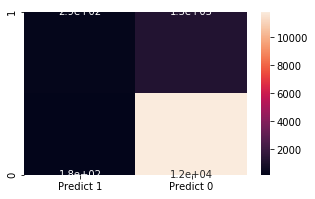

In [97]:
cm_dt = metrics.confusion_matrix(y_test, y_pred_dt, labels=[1, 0])

df_cm_dt = pd.DataFrame(cm_dt, index = ["1","0"],
                  columns = ["Predict 1","Predict 0"])
print(df_cm_dt)
plt.figure(figsize = (5,3))
sns.heatmap(df_cm_lr, annot=True)

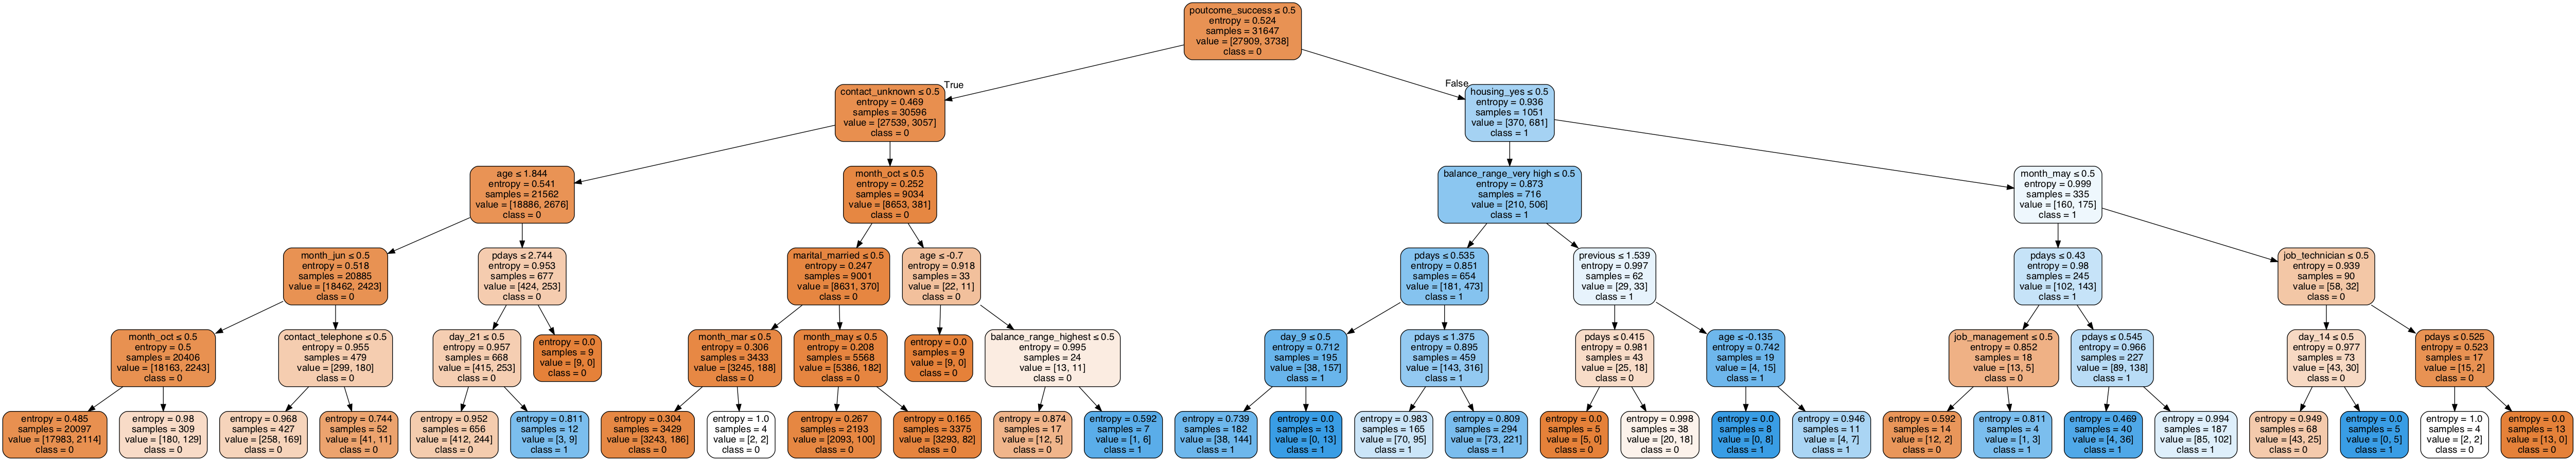

In [98]:
feature_cols = X_train_std.columns
dot_data = StringIO()
export_graphviz(dt_model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('bank_dt.png')
Image(graph.create_png())

## Ensemble Techniques

### Random Forests

In [99]:
rf_model = RandomForestClassifier(criterion = 'entropy', n_estimators=50, class_weight={0:.5,1:.5}, min_samples_leaf=3)
rf_model.fit(X_train_std, y_train)
y_pred_rf = rf_model.predict(X_test_std)

rf_report = metrics.classification_report(y_test,y_pred_rf)
print(rf_report)

              precision    recall  f1-score   support

           0       0.90      0.99      0.94     12013
           1       0.66      0.19      0.30      1551

    accuracy                           0.90     13564
   macro avg       0.78      0.59      0.62     13564
weighted avg       0.88      0.90      0.87     13564



   Predict 1  Predict 0
1        295       1256
0        152      11861


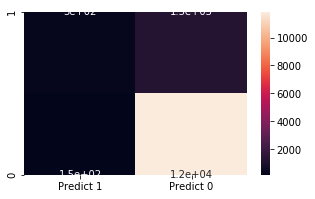

In [100]:
cm_rf = metrics.confusion_matrix(y_test, y_pred_rf, labels=[1, 0])

df_cm_rf = pd.DataFrame(cm_rf, index = ["1","0"],
                  columns = ["Predict 1","Predict 0"])
print(df_cm_rf)
plt.figure(figsize = (5,3))
sns.heatmap(df_cm_rf, annot=True)

In [101]:
#ab_model = AdaBoostClassifier(base_estimator=dt_model, n_estimators=50)
ab_model = AdaBoostClassifier( n_estimators= 100)
ab_model.fit(X_train_std,y_train)
y_pred_ab = ab_model.predict(X_test_std)

ab_report = metrics.classification_report(y_test,y_pred_ab)
print(ab_report)

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     12013
           1       0.61      0.20      0.30      1551

    accuracy                           0.89     13564
   macro avg       0.76      0.59      0.62     13564
weighted avg       0.87      0.89      0.87     13564



   Predict 1  Predict 0
1        315       1236
0        201      11812


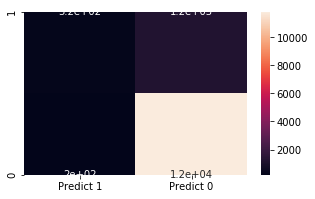

In [102]:
cm_ab = metrics.confusion_matrix(y_test, y_pred_ab, labels=[1, 0])

df_cm_ab = pd.DataFrame(cm_ab, index = ["1","0"],
                  columns = ["Predict 1","Predict 0"])
print(df_cm_ab)
plt.figure(figsize = (5,3))
sns.heatmap(df_cm_ab, annot=True)

In [103]:
bg_model = BaggingClassifier(n_estimators=70, max_samples= .7, bootstrap=True)
bg_model = bg_model.fit(X_train_std, y_train)
y_pred_bg = bg_model.predict(X_test_std)

bg_report = metrics.classification_report(y_test,y_pred_bg)
print(bg_report)

              precision    recall  f1-score   support

           0       0.91      0.97      0.94     12013
           1       0.55      0.25      0.35      1551

    accuracy                           0.89     13564
   macro avg       0.73      0.61      0.64     13564
weighted avg       0.87      0.89      0.87     13564



   Predict 1  Predict 0
1        394       1157
0        318      11695


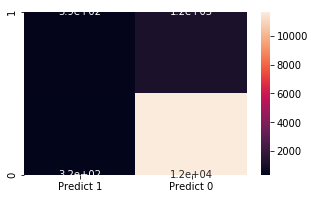

In [104]:
cm_bg = metrics.confusion_matrix(y_test, y_pred_bg, labels=[1, 0])

df_cm_bg = pd.DataFrame(cm_bg, index = ["1","0"],
                  columns = ["Predict 1","Predict 0"])
print(df_cm_bg)
plt.figure(figsize = (5,3))
sns.heatmap(df_cm_bg, annot=True)

In [105]:
gb_model = GradientBoostingClassifier(n_estimators = 70, learning_rate = 0.7)
gb_model = gb_model.fit(X_train_std, y_train)
y_pred_gb = gb_model.predict(X_test_std)

gb_report = metrics.classification_report(y_test,y_pred_gb)
print(gb_report)

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     12013
           1       0.57      0.25      0.34      1551

    accuracy                           0.89     13564
   macro avg       0.74      0.61      0.64     13564
weighted avg       0.87      0.89      0.87     13564



   Predict 1  Predict 0
1        383       1168
0        292      11721


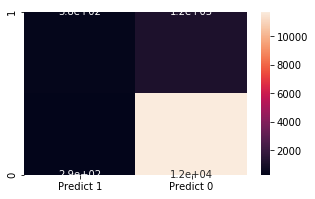

In [106]:
cm_gb = metrics.confusion_matrix(y_test, y_pred_gb, labels=[1, 0])

df_cm_gb = pd.DataFrame(cm_gb, index = ["1","0"],
                  columns = ["Predict 1","Predict 0"])
print(df_cm_gb)
plt.figure(figsize = (5,3))
sns.heatmap(df_cm_gb, annot=True)

In [110]:
Xtrain = xgb.DMatrix(X_train_std,label=y_train)
Xtest = xgb.DMatrix(X_test_std,label=y_test)
param = {
    'eta': 0.5, 
    'max_depth': 7,  
    'objective': 'binary:logistic'
    } 

steps = 10  # The number of training iterations
xgbmodel = xgb.train(param, Xtrain, steps)
pred_xgb = xgbmodel.predict(Xtest)

y_pred_xgb = np.array([int(x>0.5) for x in pred_xgb])

xgb_report = metrics.classification_report(y_test,y_pred_xgb)
print(xgb_report)

              precision    recall  f1-score   support

           0       0.90      0.98      0.94     12013
           1       0.59      0.20      0.30      1551

    accuracy                           0.89     13564
   macro avg       0.75      0.59      0.62     13564
weighted avg       0.87      0.89      0.87     13564



   Predict 1  Predict 0
1        288       1263
0        180      11833


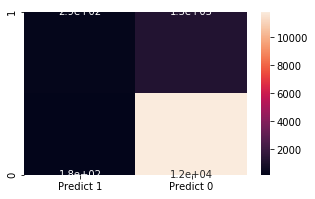

In [108]:
cm_xgb = metrics.confusion_matrix(y_test, y_pred_xgb, labels=[1, 0])

df_cm_xgb = pd.DataFrame(cm_lr, index = ["1","0"],
                  columns = ["Predict 1","Predict 0"])
print(df_cm_xgb)
plt.figure(figsize = (5,3))
sns.heatmap(df_cm_xgb, annot=True)

## Conclusion

#### For each model which has parameters to tune, a range of numbers were tried. All the different techniques and models seem to achieve similar results, with an accuracy of 89%, precision of 55-66% and recall of 19-25%. Among all, the Bagging and Gradient Decent Classifiers have better performance.